In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [3]:
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0, L=0.9):
    '''
    >>> res = bicycle_model((0.0, 0.0, np.pi/2), 1.0, 0.0); \
        print([round(x, 6) for x in res])
    [0.0, 1.0, 1.570796]
    >>> res = bicycle_model((1.0, 0.0, np.pi/2), 1, np.pi/4);   \
        print([round(x, 6) for x in res])
    [1.0, 1.0, 2.681907]
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose
    x_new = x + (v * np.cos(theta) * dt)
    y_new = y + (v * np.sin(theta) * dt)
    theta_new = theta + ((v / L) * np.tan(delta)) * dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x_new, y_new, theta_new

Finding tests in bicycle_model
Trying:
    res = bicycle_model((0.0, 0.0, np.pi/2), 1.0, 0.0);         print([round(x, 6) for x in res])
Expecting:
    [0.0, 1.0, 1.570796]
ok
Trying:
    res = bicycle_model((1.0, 0.0, np.pi/2), 1, np.pi/4);           print([round(x, 6) for x in res])
Expecting:
    [1.0, 1.0, 2.681907]
ok


In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
straight_trajectory.append(pose)    # Starting point
#fill in v and delta values
all_v = np.ones(steps)
all_delta = np.zeros(steps)
for i in range(steps):
    # Calculate new pose
    pose = bicycle_model(pose, all_v[i], all_delta[i])
    straight_trajectory.append(pose)
straight_trajectory = np.array(straight_trajectory)

In [5]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 60
circle_trajectory.append(pose)
#fill in v and delta values
all_v = np.ones(steps)
all_delta = np.ones(steps) * np.pi/4    # R = L / tan(delta) = 0.9
for (v, delta) in zip(all_v, all_delta):
    # Calculate and append new pose
    pose = bicycle_model(pose, v, delta, dt=0.1)
    circle_trajectory.append(pose)
circle_trajectory = np.array(circle_trajectory)

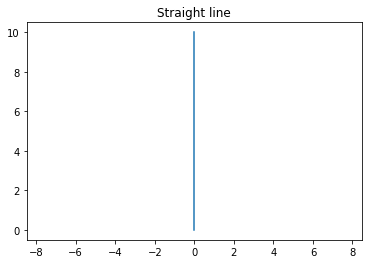

In [6]:
### Plot straight and circular trajectories
plt.figure()
plt.title("Straight line")
plt.axis('off') # Required due to a weird bug of display
plt.axes().set_aspect("equal", "datalim")   # Equal axis
plt.plot(straight_trajectory[:, 0], straight_trajectory[:, 1])
plt.show()


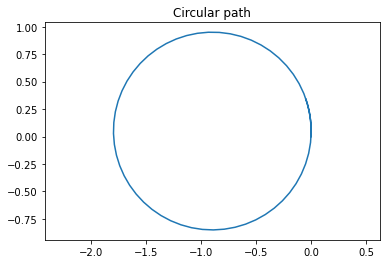

Circle radius = 0.9003150227854301


In [7]:
# Circular trajectory
plt.figure()
plt.title("Circular path")
plt.axis('off') # Required due to a weird bug of display
plt.axes().set_aspect("equal", "datalim")
plt.plot(circle_trajectory[:, 0], circle_trajectory[:, 1])
plt.show()
R = (np.max(circle_trajectory[:, 0]) - np.min(circle_trajectory[:, 0]))/2
print(f"Circle radius = {R}")

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [8]:
v_c = 1.0 # m/s
delta_c = np.pi/8 # rad/s

#calculate time taken to finish a quarter turn (pi/2)
L = 0.9
theta_dot = (v_c / L) * np.tan(delta_c) # rad / s
t_turn_real = (np.pi/2)/theta_dot
t_turn = int(np.ceil(t_turn_real))

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros
t_straight1 = int(np.ceil(10/v_c))
t_straight2 = int(np.ceil(5/v_c))
t_straight3 = int(np.ceil(8/v_c))

all_delta = [0]*t_straight1 + [delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [9]:
def get_open_loop_commands(route, vc=1.0, deltac=np.pi/12, L = 0.9):
    all_delta = np.array([])
    for command, value in route:
        if command in ["left", "right"]:    # Turning
            speed = (vc / L) * np.tan(deltac)
            delta_val = deltac * (-1 if command == "right" else 1)
            value = np.deg2rad(value)
        else:   # Straight line
            speed = vc
            delta_val = 0
        t_action_real = value / speed
        # Note: floor used here for not exaggerating turns
        t_action = int(np.floor(t_action_real))
        all_delta = np.append(all_delta, [delta_val] * t_action)
    all_v = vc * np.ones_like(all_delta)
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [10]:
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), 
                                           ("straight", 6), ("left", 85)])
print(all_v.shape, all_delta.shape)

(20,) (20,)


In [11]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
robot_trajectory.append(pose)
for v, delta in zip(all_v, all_delta):
    # Calculate new pose
    pose = bicycle_model(pose, v, delta)
    # Append new values
    robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

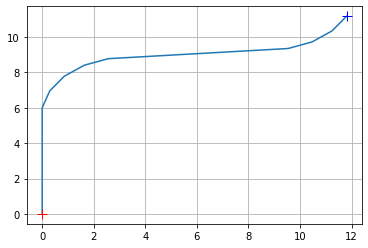

In [12]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory[:, 0], robot_trajectory[:, 1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'b+', ms=10)

### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2x^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [13]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [14]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


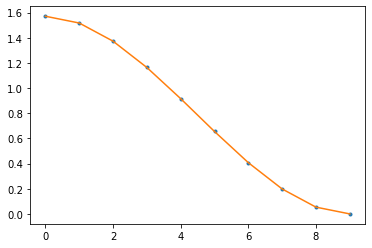

In [15]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to West)

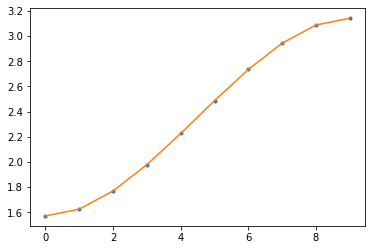

In [16]:
plt.figure()
turn_thetas = poly_turn(np.pi/2, np.pi)
plt.plot(turn_thetas,'.')
plt.plot(turn_thetas)

How does $\theta$ change when we had constant $\delta$? Plot it

Theta dot = 0.2977213249234697
Theta changes linearly from 1.5707963267948966 to 2.4639603015653058 value (radians)


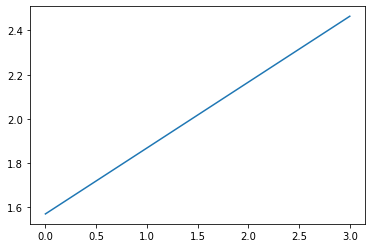

In [17]:
# Get theta dot value
const_del = np.pi/12    # Rad
const_v = 1 # m/s; assuming constant
L = 0.9 # Wheel separation
theta_dot = (const_v / L) * np.tan(const_del)
print(f"Theta dot = {theta_dot}")    # A constant = straight line
# Get theta values
time_vals = np.linspace(0, 3)   # 3 sec time plot
theta_init = np.pi/2    # Initial angle (facing north)
theta_vals = theta_init + theta_dot * time_vals
# Plot
plt.figure()
plt.plot(time_vals, theta_vals)
first_theta = theta_vals[0]
last_theta = theta_vals[-1]
print(f"Theta changes linearly from {first_theta} to {last_theta} value (radians)")


We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

In [18]:
# Theta dot values
theta_init = np.pi/2
theta_final = 0
theta_vals = poly_turn(theta_init, theta_final)
theta_dot = np.diff(theta_vals)
# Other variables
v_const = 1 # m/s
L = 0.9 # m
delta_vals = (L/v_const) * theta_dot

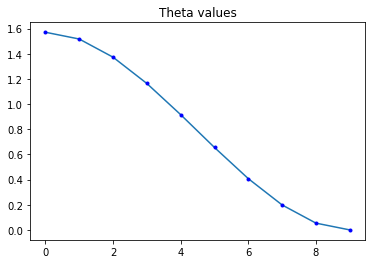

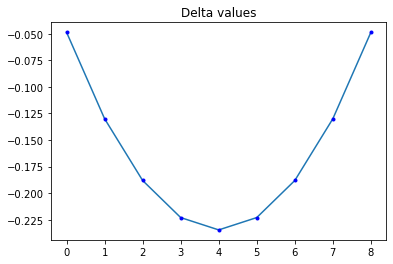

In [19]:
# Plot everything
plt.figure()
plt.title("Theta values")
plt.plot(theta_vals)
plt.plot(theta_vals, 'b.')
plt.figure()
plt.title("Delta values")
plt.plot(delta_vals)
plt.plot(delta_vals, 'b.')